In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ================= 配置 =================
MODEL_PATH = "./best_model_seed_98"  # 确保路径正确
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 加载模型（关键修改点）
print(f">>> Loading model from {MODEL_PATH}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# 修改点：在加载时直接指定 output_attentions=True
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH, 
    num_labels=2, 
    output_attentions=True 
)

# 双重保险：强制修改 config
model.config.output_attentions = True 

model.to(device)
model.eval()

# 2. 定义“找茬”探针输入
text_en_1 = "The cat sat on the mat"
text_en_2 = "The mat sat on the cat"

# 示例序列 (假设之前的 demo 序列)
seq_bio_1 = "MKLVINGFGRIGRLVTRAAF" 
seq_bio_2 = "MKLVINLFGRIGRLVTRAAF" 

def get_attention_maps(text1, text2):
    # GPT-2 没有 token_type_ids，所以我们只取 input_ids 和 attention_mask
    inputs = tokenizer(text1, text2, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        # 这里虽然 config 改了，但为了保险再传一次参数
        outputs = model(**inputs, output_attentions=True)
    
    # 调试检查：如果这里报错，说明模型真的没吐出 attention
    if outputs.attentions is None:
        raise ValueError("Model did not return attentions! Check config.")
        
    # outputs.attentions 是一个 tuple，包含每一层的 attention tensor
    # 形状: (batch, num_heads, seq_len, seq_len)
    # stack 后形状: (num_layers, batch, num_heads, seq_len, seq_len)
    # squeeze(1) 去掉 batch 维度 -> (num_layers, num_heads, seq_len, seq_len)
    attentions = torch.stack(outputs.attentions).squeeze(1).cpu() 
    
    return attentions, inputs['input_ids'][0]

# 3. 获取注意力权重 (现在应该不会报错了)
print(">>> Running inference to get attention maps...")
attns_en, ids_en = get_attention_maps(text_en_1, text_en_2)
tokens_en = tokenizer.convert_ids_to_tokens(ids_en)

print("✅ Attention maps extracted successfully!")

# 4. 自动筛选“找茬 Head”
# 找到 Sent1 和 Sent2 的分界线
# 注意：GPT-2 Tokenizer 对空格敏感，单独 encode text1 可能会少一个前导空格，导致长度差1
# 最稳妥的方法是看 inputs_ids
len_1 = len(tokenizer(text_en_1)['input_ids'])
len_total = len(ids_en)

print(f"Seq Length: {len_total}, Split at: {len_1}")

scores = []

# 遍历中间层 (Layer 4-9)
for layer in range(4, 10): 
    for head in range(12):
        attn_mat = attns_en[layer, head]
        
        # 提取 Cross Attention 区域: Sent2 关注 Sent1
        cross_attn = attn_mat[len_1:, :len_1]
        
        # 计算对角线强度
        min_len = min(cross_attn.shape)
        if min_len > 0:
            diag_score = cross_attn.diagonal(offset=0)[:min_len].sum().item()
            scores.append((layer, head, diag_score))

# 排序
scores.sort(key=lambda x: x[2], reverse=True)
if len(scores) > 0:
    top_layer, top_head, top_score = scores[0]
    print(f"\n>>> 🏆 Top Difference Detector Candidate: Layer {top_layer}, Head {top_head}")
    print(f"Top 5 Candidates: {scores[:5]}")
    
    # ================= 绘图代码准备 =================
    # 把刚才跑出来的 top_layer 和 top_head 传给变量，方便下一个单元格绘图
    TARGET_LAYER = top_layer
    TARGET_HEAD = top_head
else:
    print("❌ No valid attention scores found. Check sequence lengths.")

>>> Loading model from ./best_model_seed_98...
>>> Running inference to get attention maps...
✅ Attention maps extracted successfully!
Seq Length: 12, Split at: 6

>>> 🏆 Top Difference Detector Candidate: Layer 5, Head 9
Top 5 Candidates: [(5, 9, 1.387974500656128), (4, 7, 1.2820329666137695), (5, 11, 1.2159371376037598), (6, 2, 1.028128981590271), (9, 9, 1.0105059146881104)]


>>> Visualizing Layer 5, Head 9...


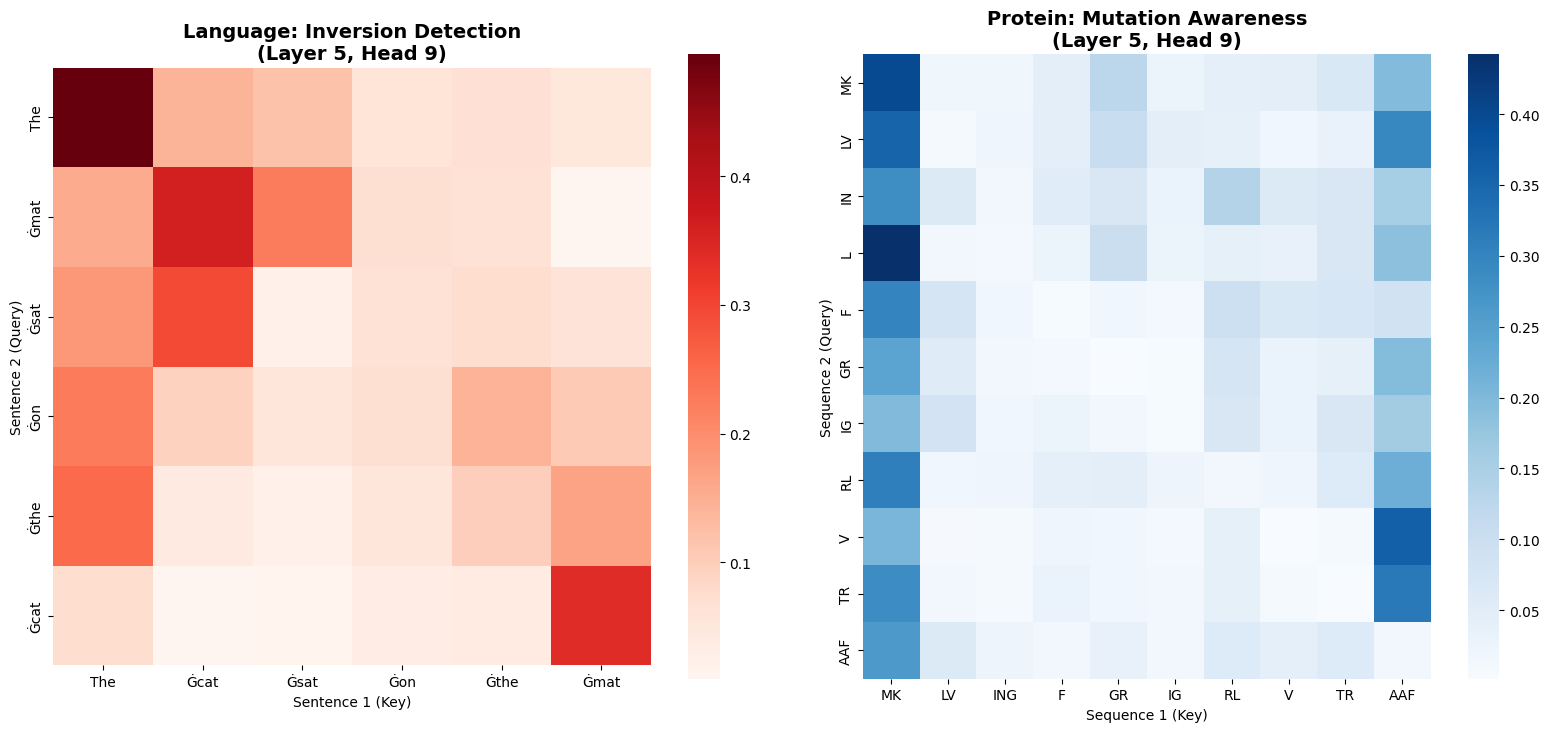

In [3]:
import seaborn as sns

# ================= 绘图参数 =================
TARGET_LAYER = top_layer  # 使用刚才筛出来的层
TARGET_HEAD = top_head    # 使用刚才筛出来的头
# 或者手动指定，比如您之前提到的:
# TARGET_LAYER = 7
# TARGET_HEAD = 4 
# ===========================================

def plot_cross_modal_heatmap(layer, head):
    # 1. 获取数据
    attn_en, ids_en = get_attention_maps(text_en_1, text_en_2)
    attn_bio, ids_bio = get_attention_maps(seq_bio_1, seq_bio_2)
    
    tokens_en = tokenizer.convert_ids_to_tokens(ids_en)
    # 生物序列分词后可能是字符级，也可能合并，为了展示清晰，我们只看前20个token
    tokens_bio = tokenizer.convert_ids_to_tokens(ids_bio)
    
    # 2. 提取特定 Head 的矩阵
    # 英语
    mat_en = attn_en[layer, head].numpy()
    # 为了视觉美观，只取 Sent2 关注 Sent1 的部分 (左下角)
    len_en_1 = len(tokenizer(text_en_1)['input_ids'])
    # 切片: Rows=Sent2, Cols=Sent1
    viz_en = mat_en[len_en_1:, :len_en_1] 
    x_labels_en = tokens_en[:len_en_1]
    y_labels_en = tokens_en[len_en_1:]

    # 蛋白质
    mat_bio = attn_bio[layer, head].numpy()
    len_bio_1 = len(tokenizer(seq_bio_1)['input_ids'])
    viz_bio = mat_bio[len_bio_1:, :len_bio_1]
    x_labels_bio = tokens_bio[:len_bio_1]
    y_labels_bio = tokens_bio[len_bio_1:]

    # 3. 绘图
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # 左图：Language
    sns.heatmap(viz_en, xticklabels=x_labels_en, yticklabels=y_labels_en, 
                cmap="Reds", square=True, cbar=True, ax=axes[0])
    axes[0].set_title(f"Language: Inversion Detection\n(Layer {layer}, Head {head})", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("Sentence 1 (Key)")
    axes[0].set_ylabel("Sentence 2 (Query)")
    
    # 右图：Protein
    # 如果序列太长，只截取前 15x15 展示细节
    limit = 15
    sns.heatmap(viz_bio[:limit, :limit], 
                xticklabels=x_labels_bio[:limit], yticklabels=y_labels_bio[:limit], 
                cmap="Blues", square=True, cbar=True, ax=axes[1])
    axes[1].set_title(f"Protein: Mutation Awareness\n(Layer {layer}, Head {head})", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Sequence 1 (Key)")
    axes[1].set_ylabel("Sequence 2 (Query)")

    plt.tight_layout()
    plt.show() # plt.savefig("cross_modal_attention.pdf")

print(f">>> Visualizing Layer {TARGET_LAYER}, Head {TARGET_HEAD}...")
plot_cross_modal_heatmap(TARGET_LAYER, TARGET_HEAD)